### Imported libreries

In [1]:
# Data manipulation

import pandas as pd
import numpy as np
import json
import pickle
import math

# Data visualization

import matplotlib.pyplot as plt
import seaborn as sns

# Feature engineering & model preparation

from sklearn.model_selection import train_test_split


from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import f_classif, SelectKBest


# Functions
from utils import *

### 1. Data collection

In [2]:
df = pd.read_csv("https://breathecode.herokuapp.com/asset/internal-link?id=929&path=medical_insurance_cost.csv")

df.to_excel("../data/raw/df.xlsx", index = False)

df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


**Description and types of Data**

- `age` --> Age of primary beneficiary (numerical)

- `gender` --> Gender of the primary beneficiary (categorical)

- `bmi` --> body mass index (numerical)

- `children` --> Number of children/dependents covered by health insurance (numerical)

- `smoker` --> Are you a smoker? (categorical)

- `region` --> Beneficiary's residential area in the USA: Northeast, Southeast, Southwest, Northwest (categorical)

- `charges` --> Health insurance premium (numerical)

### 2. Exploration anda data cleaning

In [38]:
target = "charges"

rows, columns = df.shape
print(f"The dimensions of this dataset are {rows} rows and {columns} columns")

The dimensions of this dataset are 1338 rows and 7 columns


In [4]:
# Information about the data types and non-null values
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   str    
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   str    
 5   region    1338 non-null   str    
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), str(3)
memory usage: 73.3 KB


#### Visualization of null values

In [5]:
missing_df = missing_values_summary(df)
missing_df

No missing values were found in the dataset.


""


In [6]:
unknown_df = unknown_values_summary(df, "unknown")
unknown_df

There are no unknown values in the dataset.


""


**Conclusions:**

- The dataset contains 1,338 rows and 7 columns, where each row represents a client of the insurer and each column describes demographic, physiological and lifestyle characteristics, along with the variable target `charges`, which correspond to the cost of health insurance.

- There are no null or unknown values ​​in the dataset, which greatly simplifies the data cleaning and preprocessing phase.

- The dataset contains 3 categorical features and 4 numerical features.

- Variables such as `smoker` and `BMI` could have a significant influence on insurance costs, as they are directly related to health risks. Similarly, `age` is also a relevant factor, since medical costs tend to increase with age.

#### Visualization of duplicatied values

In [7]:
filt_df = remove_duplicates(df)

filt_df.head()

Number of duplicate rows: 1
Duplicates removed. The new shape is: 1337 rows and 7 columns


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


#### Drop irrelevant variables

In [8]:
# Although some variables such as sex or region may have a minor impact on cost prediction, it was decided 
# to retain them to avoid loss of potentially relevant information, given the small number of variables.

"""filt_df.drop(["duration"], axis= 1, inplace= True)
filt_df.info()"""

'filt_df.drop(["duration"], axis= 1, inplace= True)\nfilt_df.info()'

### 3. Analysis of univariate variables

#### Categorical variables

/tmp/ipykernel_9463/1068707840.py:1: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  cat_cols = filt_df.select_dtypes(include=['object', 'category']).columns.tolist()


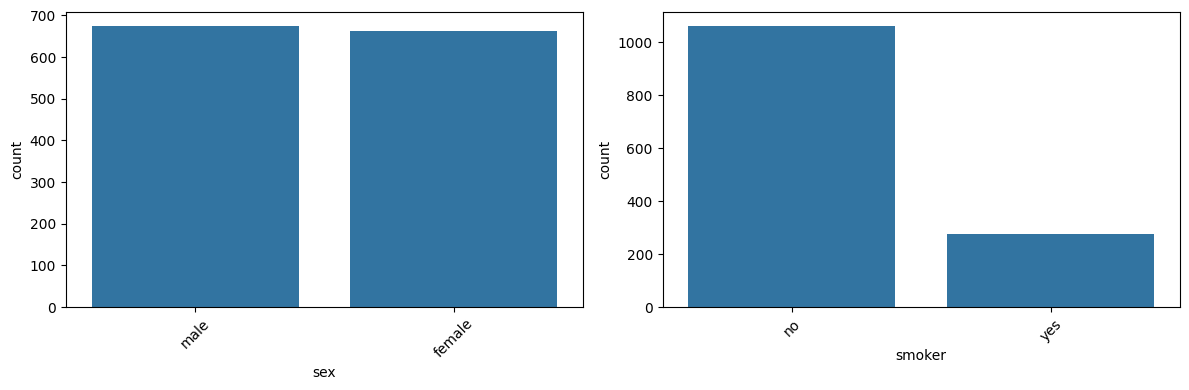

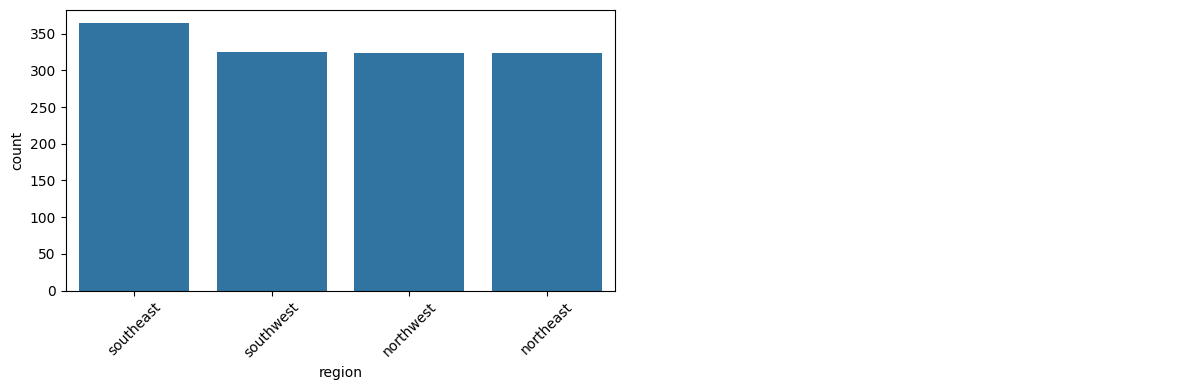

In [9]:
cat_cols = filt_df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = filt_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

for i in range(0, len(cat_cols), 2):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.countplot(ax=axes[0], data=filt_df, x=cat_cols[i], order=filt_df[cat_cols[i]].value_counts().index)
    axes[0].tick_params(axis='x', rotation=45)

    
    if i+1 < len(cat_cols):
        sns.countplot(ax=axes[1], data=filt_df, x=cat_cols[i+1], order=filt_df[cat_cols[i+1]].value_counts().index)
        axes[1].tick_params(axis='x', rotation=45)
    else:
        axes[1].axis("off")
    
    plt.tight_layout()
    plt.show()

**Conclusions:**

- `sex`: The dataset is fairly balanced between male and female clients, with no significant dominance of one gender over the other.

- `smoker`: Most individuals are non-smokers, while smokers represent a smaller portion of the dataset, indicating a clear class imbalance in this variable.

- `region`: Clients are relatively evenly distributed across the four regions (northeast, southeast, southwest, and northwest), suggesting no strong regional bias in the data.

#### Numeric variables

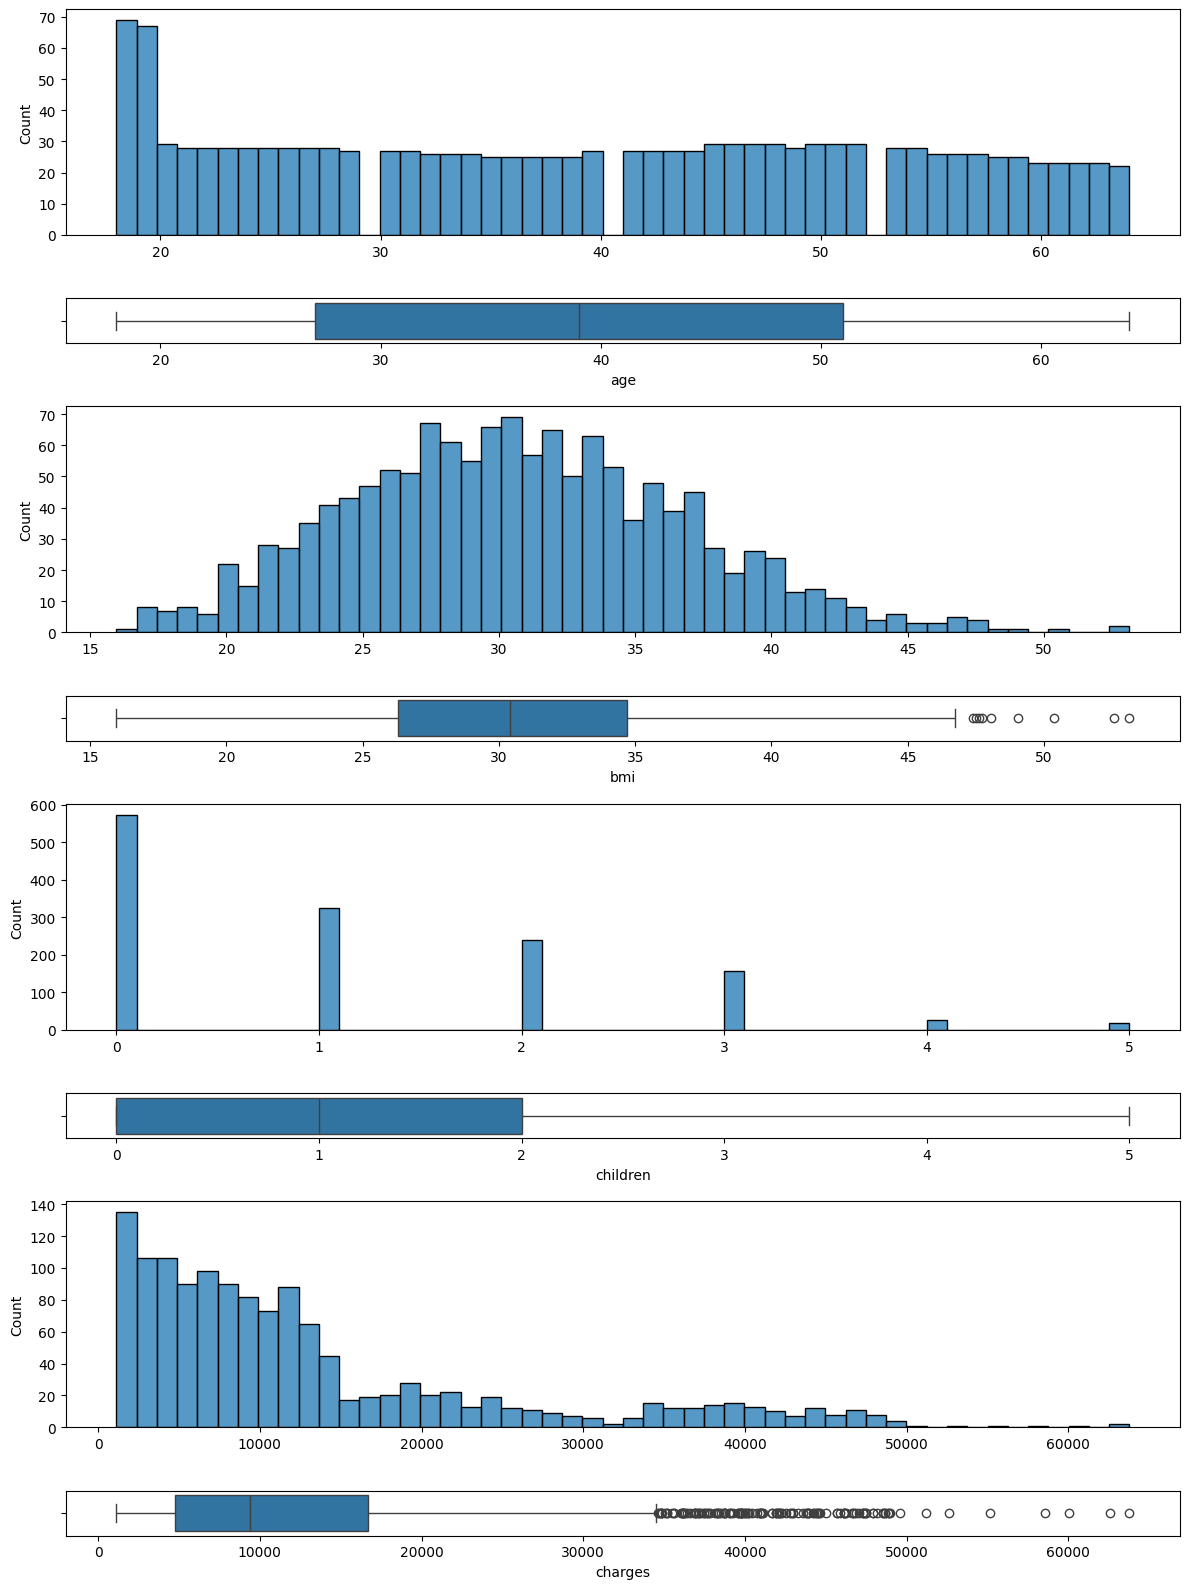

In [10]:
"""
df_filtered_uni = filt_df.copy()
# Depending on which formula best suits my data (percentile or interquartile range)


for col in numerical_cols:
    lower = df[col].quantile(0.01)
    upper = df[col].quantile(0.99)
    df_filtered_uni = df_filtered_uni[(df_filtered_uni[col] >= lower) & 
                                      (df_filtered_uni[col] <= upper)]
    

    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    df_filtered_uni = df_filtered_uni[(df_filtered_uni[col] >= Q1 - 1.5 * IQR) & 
                                      (df_filtered_uni[col] <= Q3 + 1.5 * IQR)]

"""

fig, axes = plt.subplots(
    nrows=len(numerical_cols)*2, 
    ncols=1, 
    figsize=(12, 4*len(numerical_cols)),
    gridspec_kw={'height_ratios':[5,1]*len(numerical_cols)}
)

for i, col in enumerate(numerical_cols):
    row_hist = i*2
    row_box = i*2 + 1

    sns.histplot(ax=axes[row_hist], data=filt_df, x=col, bins=50, kde=False).set(xlabel=None)
    sns.boxplot(ax=axes[row_box], data=filt_df, x=col)

plt.tight_layout()
plt.show()

**Conclusions:**

- `Age`: The age distribution is fairly uniform across ages and no outliers.

- `bmi`: BMI shows a near-normal distribution with slight right skewness, with most values concentrated in typical health-related ranges.

- `children`: The majority of individuals have between 0 and 2 children, with higher numbers of dependents being relatively rare.

- `charges`: Insurance charges present a highly right-skewed distribution suggesting the presence of high-cost subgroups and a strong variability in medical expenses.

### Analysis multivariate 

#### Analysis Numerical-Numerical

We need factorize the target for compare it with the rest of numerical variables.

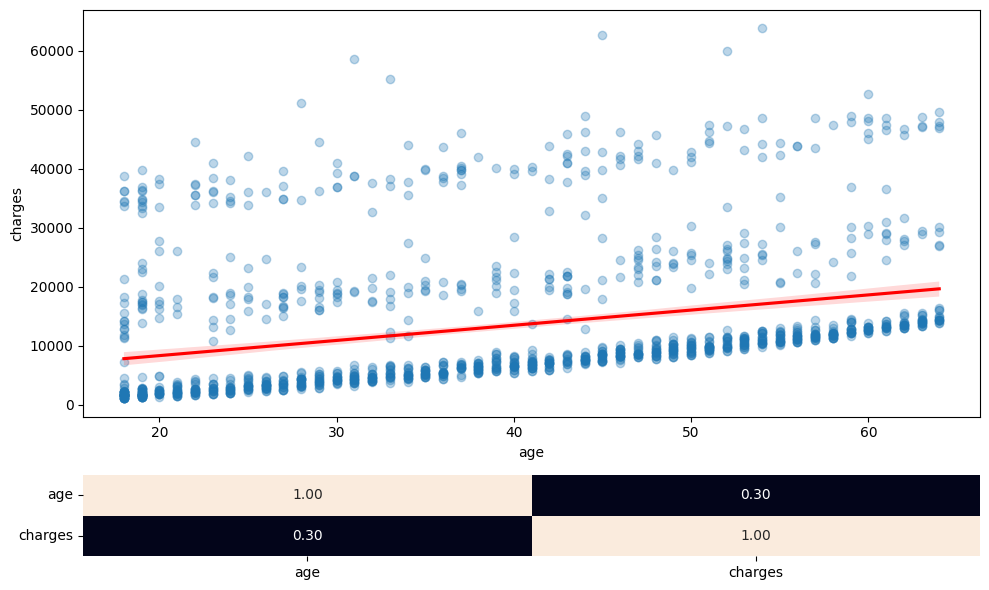

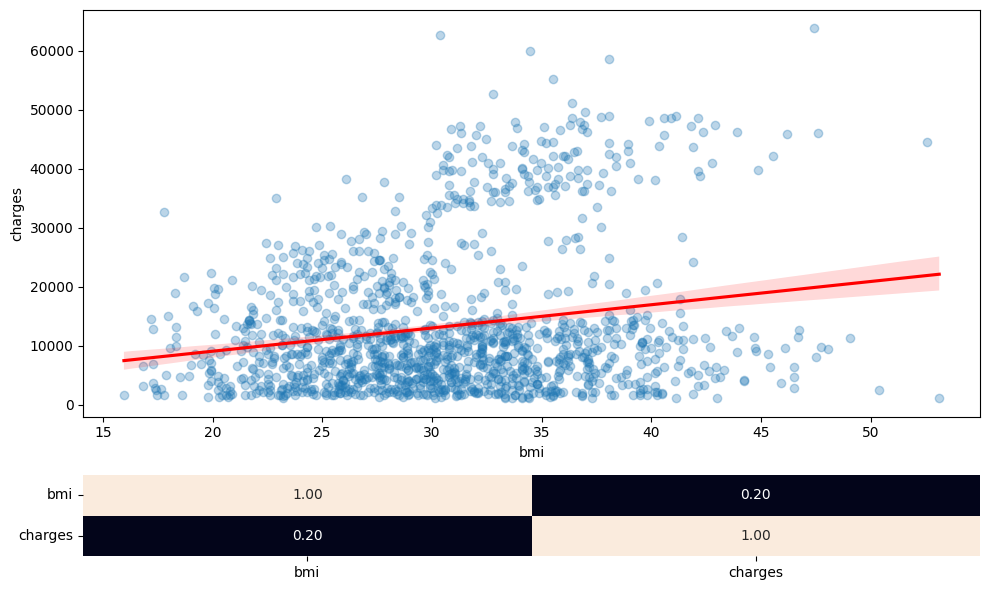

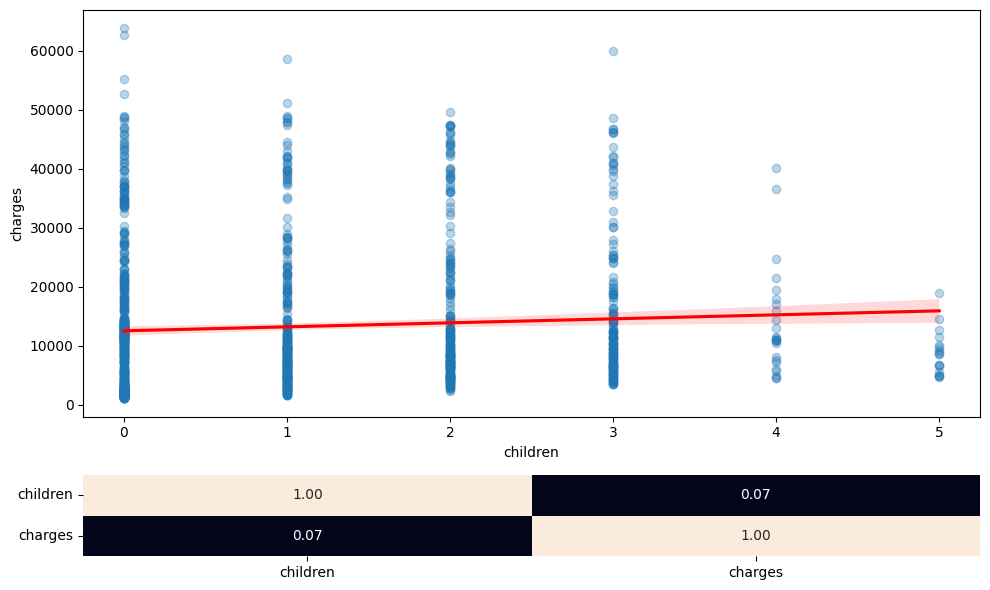

In [11]:
# total_data = factorize_categorical(filt_df)

"""
df_filtered_multi = filt_df.copy()

for col in numerical_cols:
    lower = df_filtered_multi[col].quantile(0.01)
    upper = df_filtered_multi[col].quantile(0.99)
    df_filtered_multi = df_filtered_multi[(df_filtered_multi[col] >= lower) & 
                                            (df_filtered_multi[col] <= upper)]



    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    df_filtered_multi = df_filtered_multi[(df_filtered_multi[col] >= Q1 - 1.5 * IQR) & 
                                      (df_filtered_multi[col] <= Q3 + 1.5 * IQR)]

"""

for col in numerical_cols:
    if col == target:
        continue  
    fig, axis = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios':[5,1]})

    sns.regplot(
        ax=axis[0],
        data=filt_df,
        x=col,
        y=target,
        scatter_kws={'alpha':0.3},
        line_kws={'color':'red'}
    )

    sns.heatmap(
        filt_df[[col, target]].corr(),
        annot=True,
        fmt=".2f",
        ax=axis[1],
        cbar=False
    )

    plt.tight_layout()
    plt.show()

**Conclusions:**


- There is a clear positive trend; older clients tend to have higher insurance costs, reflecting the increasing health risks with age.

- Individuals with higher BMI generally incur higher insurance charges, although the relationship is not perfectly linear and shows some variability.

- The number of children shows very little correlation with insurance costs, suggesting it has minimal impact on the target.

- Overall, age and BMI appear as the most influential numerical features for predicting insurance charges


#### Analysis Categorical-Categorical

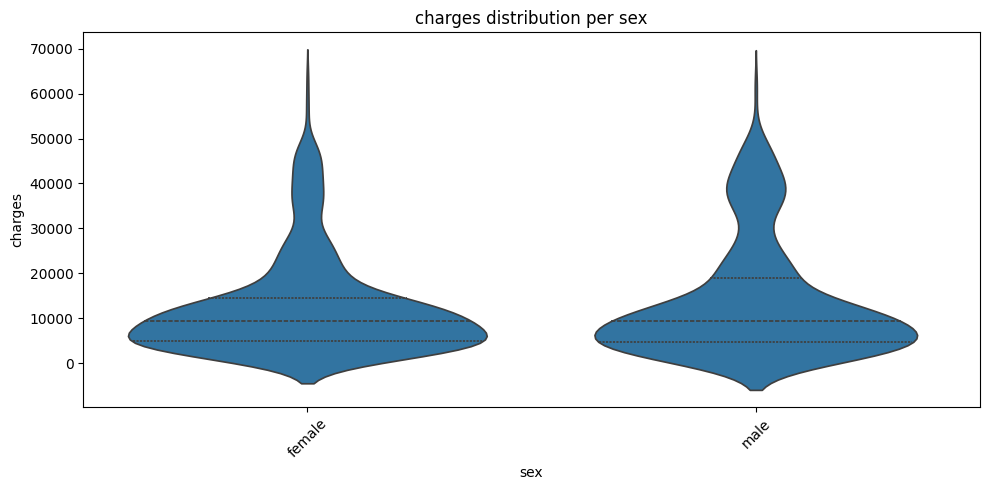

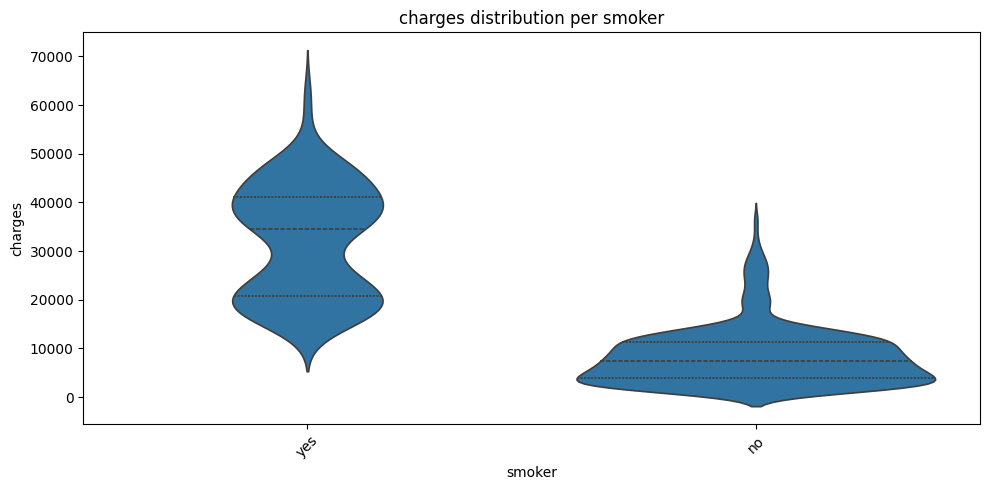

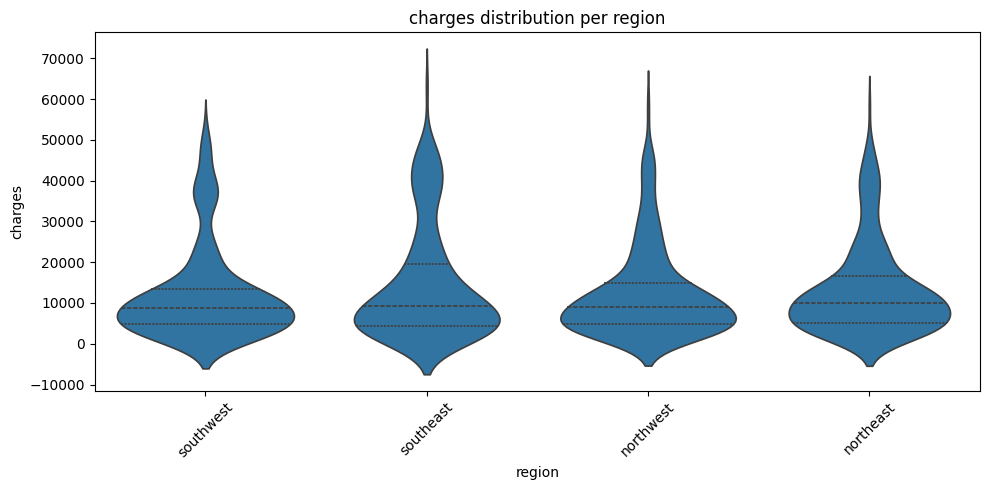

In [12]:
for col in cat_cols:
    if col == target:
        continue
    
    plt.figure(figsize=(10,5))
    sns.violinplot(
        data=filt_df,
        x=col,
        y=target,
        inner="quartile"
    )
    
    plt.title(f"{target} distribution per {col}")
    plt.ylabel(f"{target}")
    plt.xlabel(col)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

**Conclusions:**

- Smokers incur significantly higher insurance costs compared to non-smokers. The distribution shows a clear separation, making smoking status a major predictor of insurance charges.

- The distribution of charges is very similar for males and females, indicating that gender has minimal impact on insurance costs.

- Some small differences exist among regions, suggesting slight regional variation in insurance costs. The effect is noticeable but much smaller than the impact of smoking.

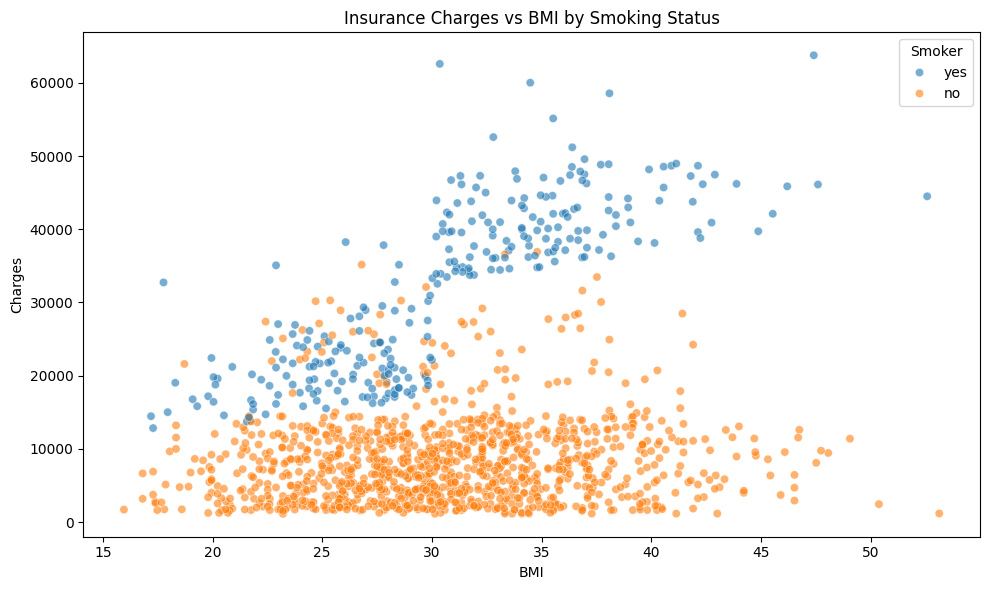

In [13]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=filt_df,
    x='bmi',
    y='charges',
    hue='smoker',
    alpha=0.6
)
plt.title("Insurance Charges vs BMI by Smoking Status")
plt.xlabel("BMI")
plt.ylabel("Charges")
plt.legend(title="Smoker")
plt.tight_layout()
plt.show()

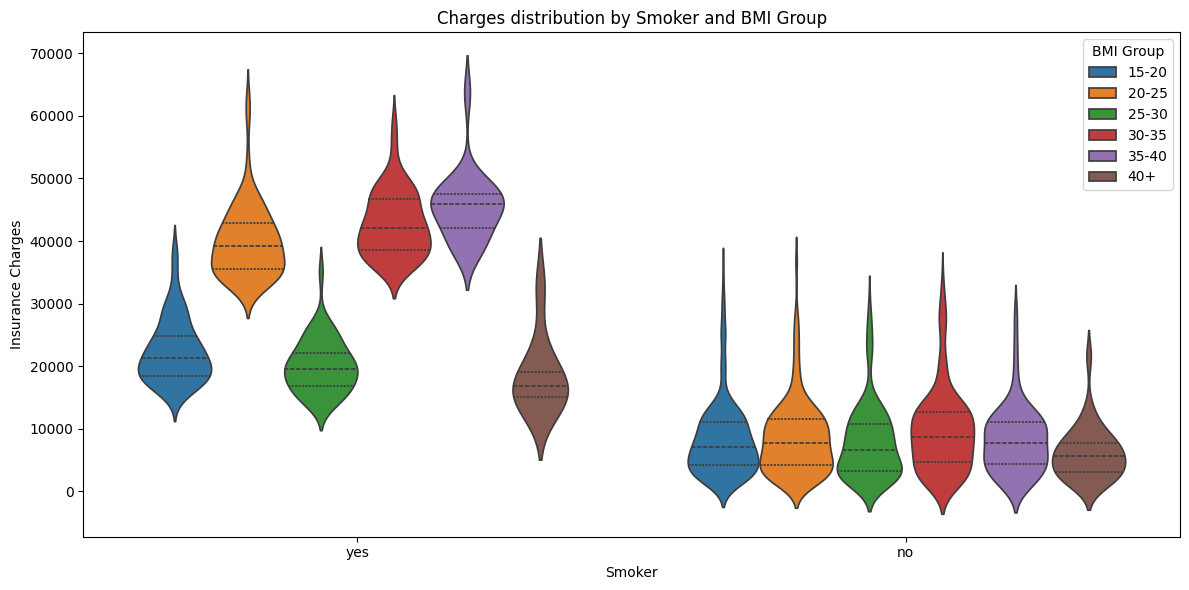

In [14]:
df_violin = filt_df.copy()

df_violin['bmi_group'] = pd.cut(
    df_violin['bmi'],
    bins=[15, 20, 25, 30, 35, 40, 55],
    labels=['15-20','20-25','25-30','30-35','35-40','40+'],
    include_lowest=True
)


plt.figure(figsize=(12,6))
sns.violinplot(
    data=df_violin,
    x='smoker',
    y='charges',
    hue='bmi_group',
    inner='quartile'
)
plt.title("Charges distribution by Smoker and BMI Group")
plt.ylabel("Insurance Charges")
plt.xlabel("Smoker")
plt.legend(title='BMI Group', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

**Conclusions:**
- Smokers incur significantly higher insurance costs than non-smokers, especially when they have a high BMI

- The distribution of charges increases with BMI, particularly for smokers in higher BMI groups (30+).

#### Correlation matrix

Categorical cols: ['sex', 'smoker', 'region']


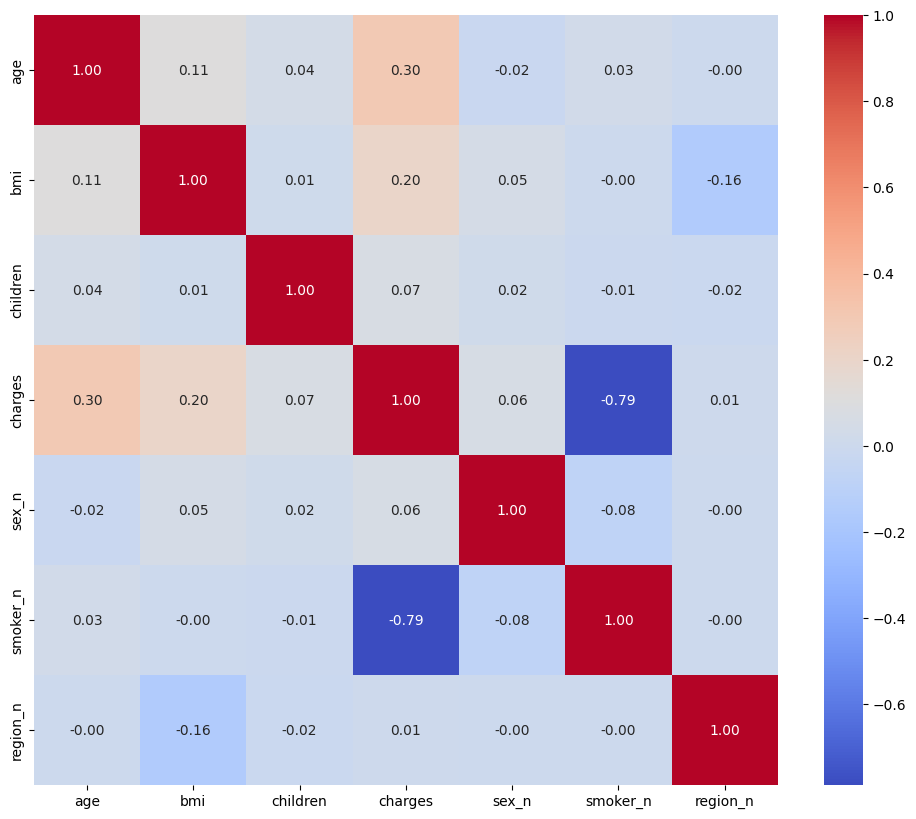

In [15]:
total_data = factorize_categorical(filt_df)
plot_correlation_heatmap(total_data)

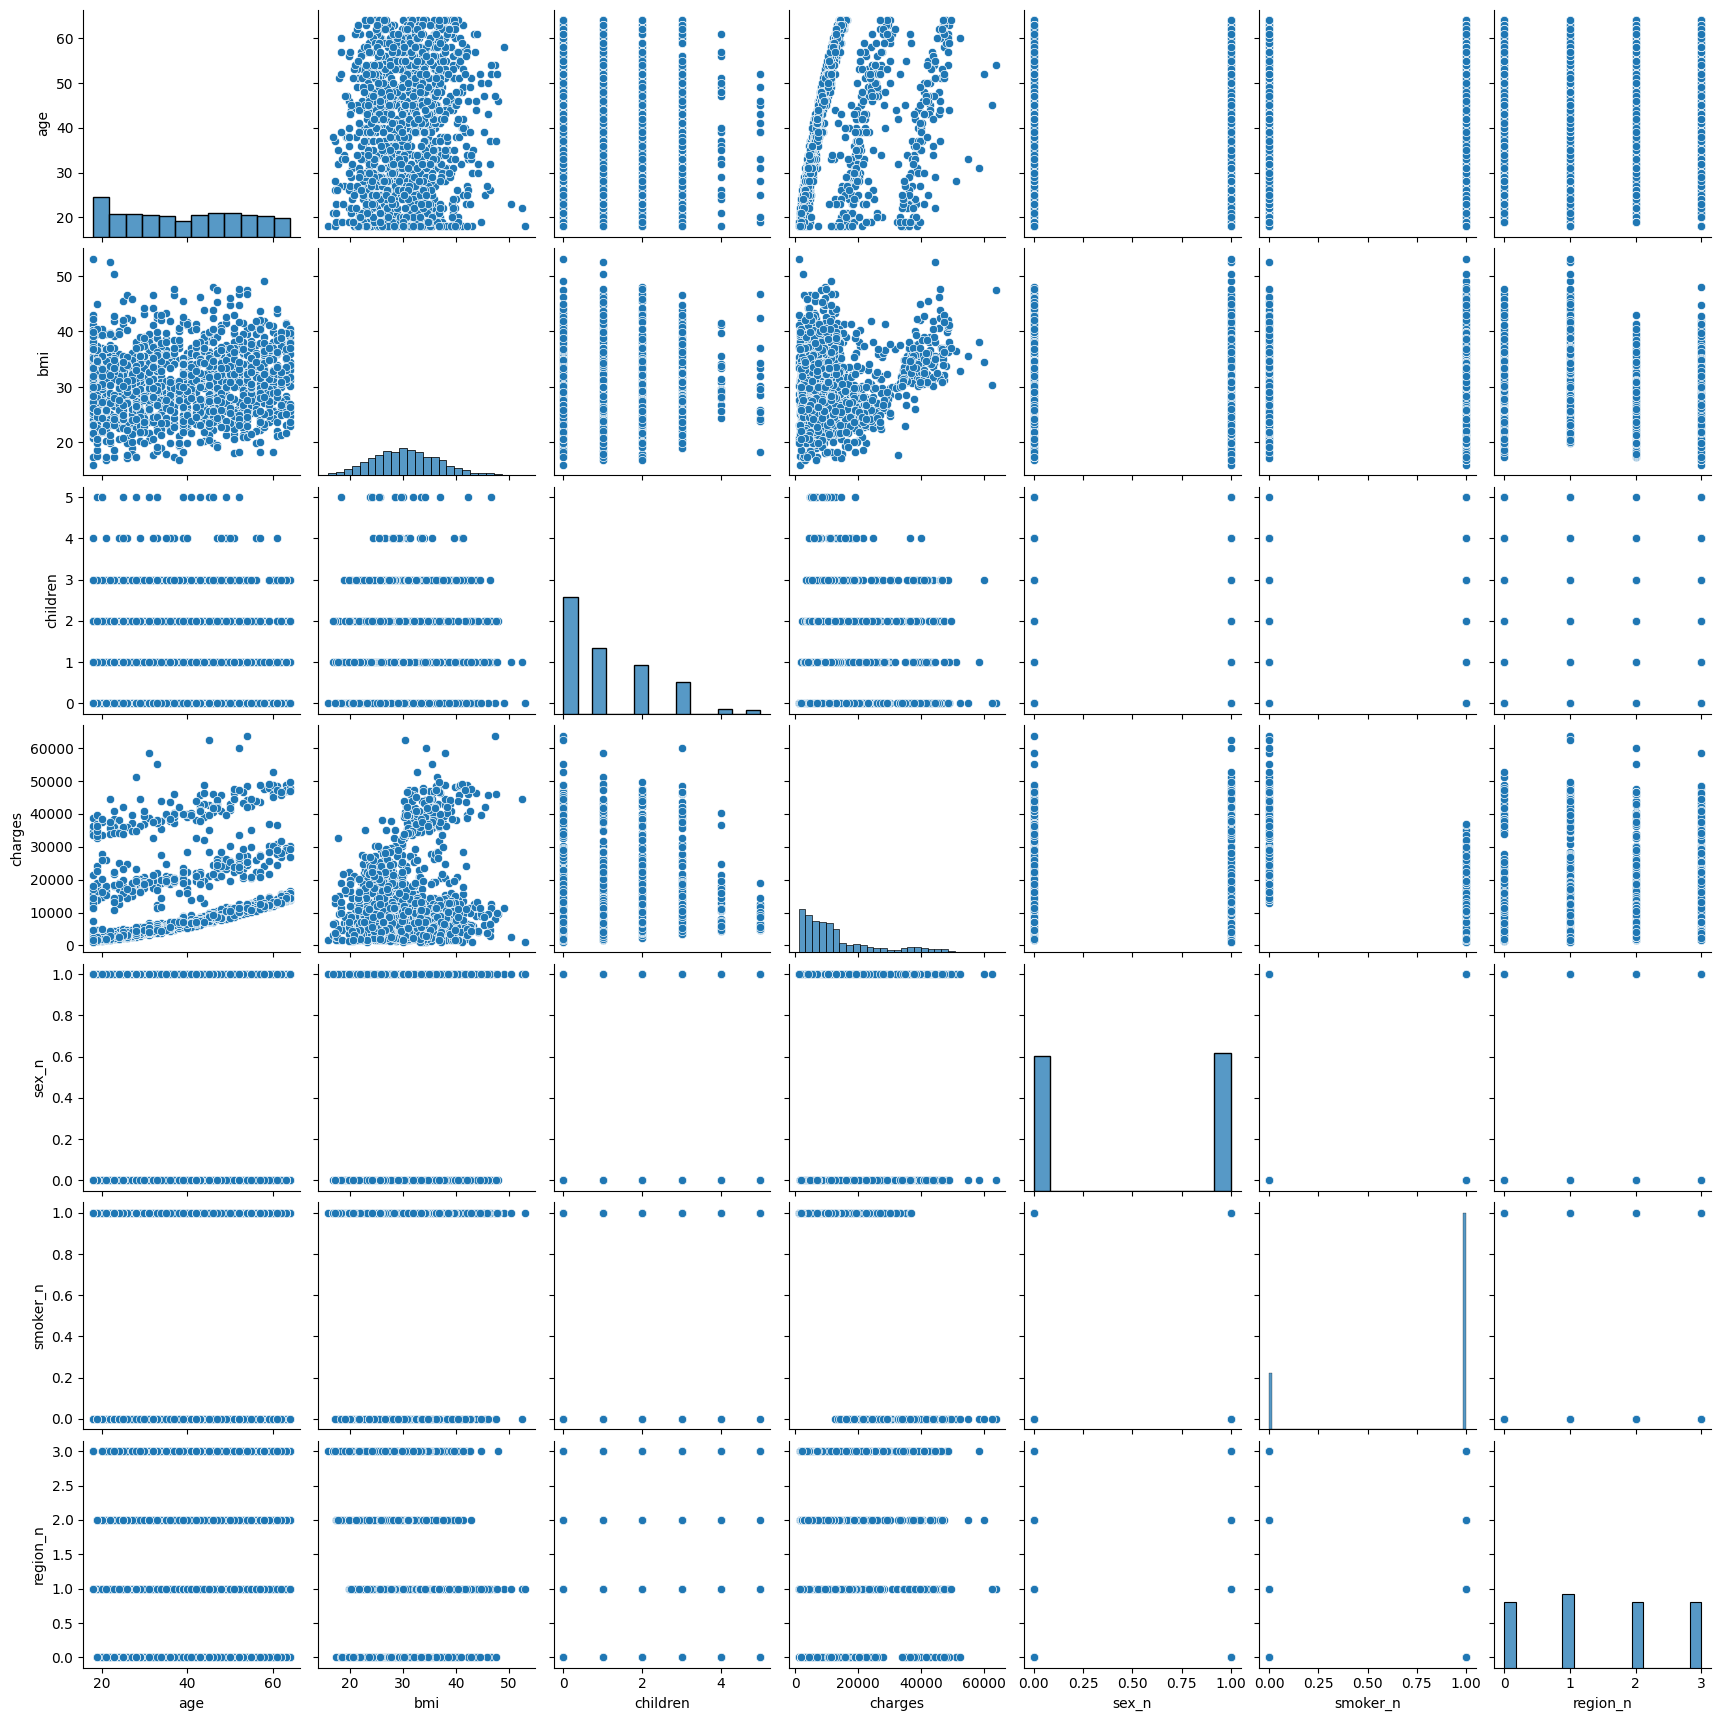

In [16]:
sns.pairplot(data = total_data)

### Featuure engineering

#### Outliers analysis

In [17]:
# Drop categoricals variables

FINAL_COLS = total_data.select_dtypes(include='object').columns.tolist()
total_data = total_data.drop(columns=FINAL_COLS)

total_data.head()

/tmp/ipykernel_9463/4040233451.py:3: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  FINAL_COLS = total_data.select_dtypes(include='object').columns.tolist()


,age,bmi,children,charges,sex_n,smoker_n,region_n
0,19,27.900,0,16884.92400,0,0,0
1,18,33.770,1,1725.55230,1,1,1
2,28,33.000,3,4449.46200,1,1,1
3,33,22.705,0,21984.47061,1,1,2
4,32,28.880,0,3866.85520,1,1,2


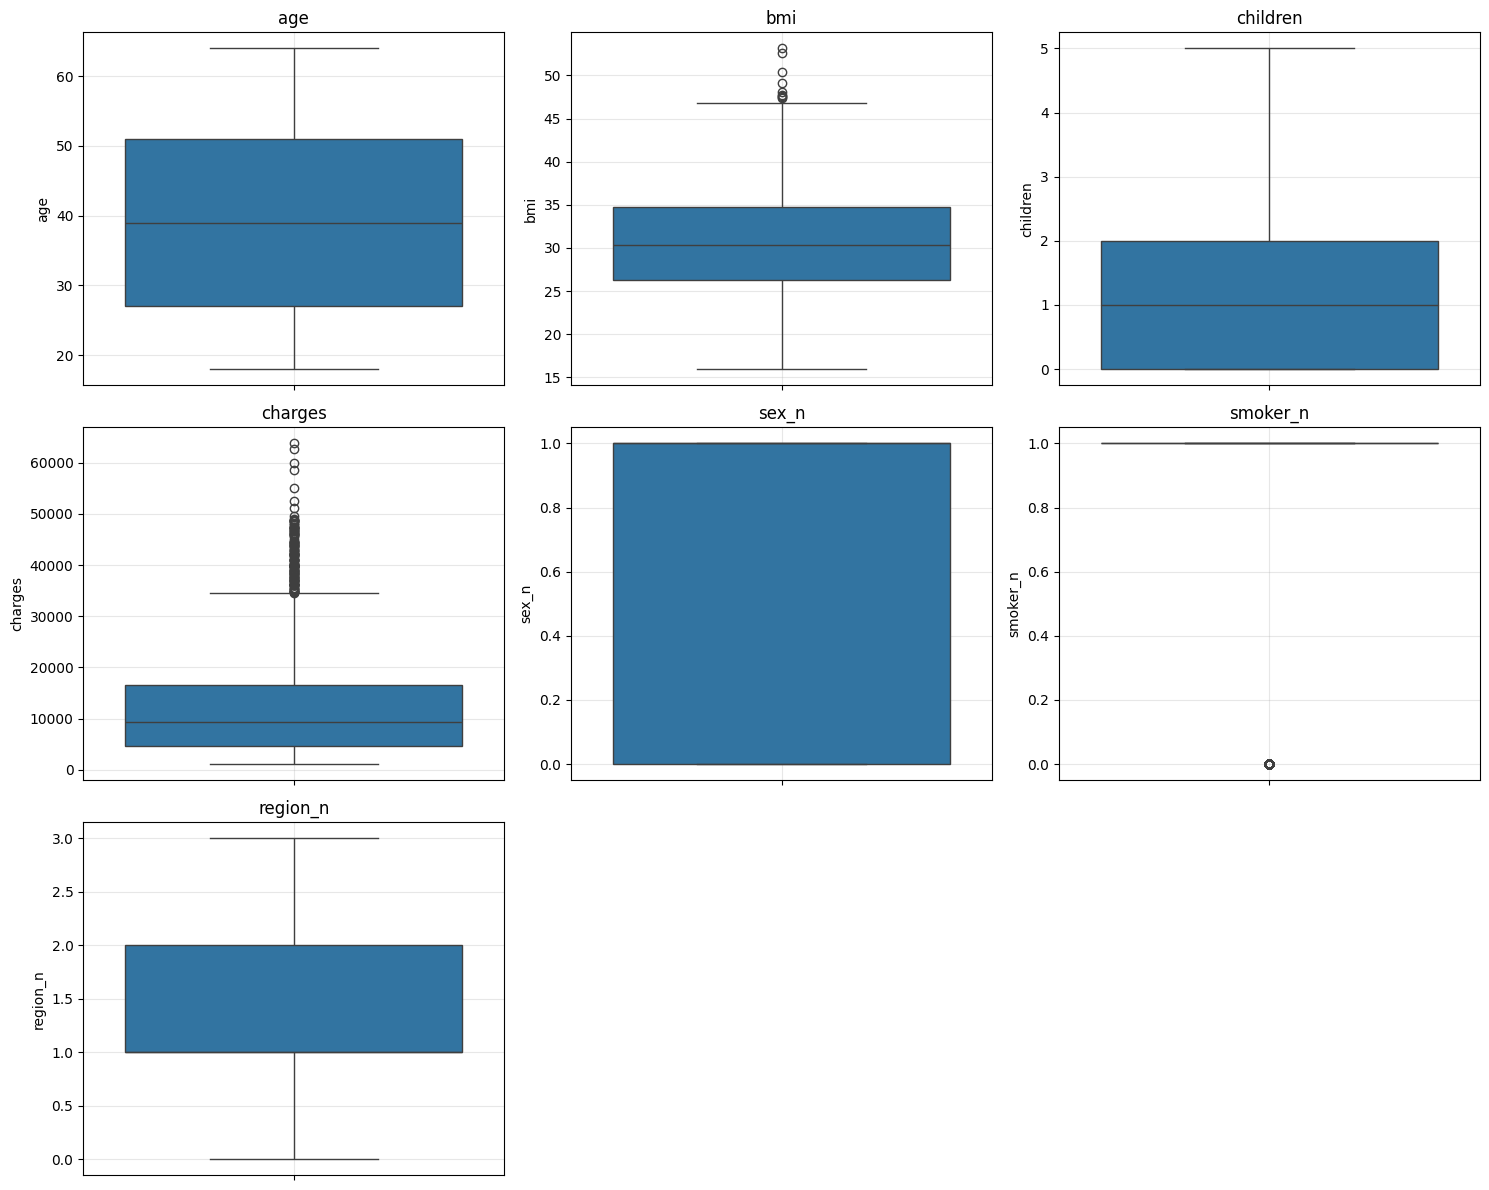

In [18]:
def plot_boxplots(
    df,
    cols=None,
    n_cols=3,
    figsize_per_plot=(5, 4)
):

    if cols is None:
        cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

    n_plots = len(cols)
    n_rows = math.ceil(n_plots / n_cols)

    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        figsize=(figsize_per_plot[0] * n_cols,
                 figsize_per_plot[1] * n_rows)
    )

    axes = axes.flatten()

    for i, col in enumerate(cols):
        sns.boxplot(
            ax=axes[i],
            data=df,
            y=col
        )
        axes[i].set_title(col)
        axes[i].grid(alpha=0.3)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

plot_boxplots(total_data)

#### Cap outliers variables and save JSON

In [19]:
total_data_with_outliers = total_data.copy()
total_data_without_outliers = total_data.copy()


outliers_cols = [col for col in numerical_cols if col != target]

outliers_dict = {}

for column in outliers_cols:
  total_data_without_outliers, limits = replace_outliers(column, total_data_without_outliers)
  outliers_dict[column] = limits

outliers_dict
with open("../data/interim/outliers_dict.xlsx", "w") as f:
  json.dump(outliers_dict, f)


No outliers detected in age. No changes made.

The lower_limit of variable bmi is 13.675 and the upper_limit is 47.315 and the IQR is 8.41

No outliers detected in children. No changes made.


#### Missing values analysis

In [29]:
total_data_with_outliers.head()

,age,bmi,children,charges,sex_n,smoker_n,region_n
0,19,27.900,0,16884.92400,0,0,0
1,18,33.770,1,1725.55230,1,1,1
2,28,33.000,3,4449.46200,1,1,1
3,33,22.705,0,21984.47061,1,1,2
4,32,28.880,0,3866.85520,1,1,2


In [22]:
print("TOTAL_DATA_WITH_OUTLIERS:\n")
check_missing_values(total_data_with_outliers)

TOTAL_DATA_WITH_OUTLIERS:

No missing values were found in the dataset.


""


In [25]:
print("TOTAL_DATA_WITHOUT_OUTLIERS:\n")
check_missing_values(total_data_without_outliers)

TOTAL_DATA_WITHOUT_OUTLIERS:

No missing values were found in the dataset.


""


Since we don't have any null values ​​in the dataset, we skip this step.

In [30]:
"""median_cols = [

]

mean_cols = [

]

mode_cols = [
    "job_n", "education_n", "marital_n", "default_n", "housing_n", "loan_n"
]


total_data_with_outliers = fill_missing_values(total_data_with_outliers, median_cols= median_cols, mode_cols= mode_cols, mean_cols= mean_cols)

total_data_without_outliers = fill_missing_values(total_data_without_outliers, median_cols= median_cols, mode_cols= mode_cols, mean_cols= mean_cols)

print("TOTAL_DATA_WITH_OUTLIERS:\n")
check_missing_values(total_data_with_outliers)"""

'median_cols = [\n\n]\n\nmean_cols = [\n\n]\n\nmode_cols = [\n    "job_n", "education_n", "marital_n", "default_n", "housing_n", "loan_n"\n]\n\n\ntotal_data_with_outliers = fill_missing_values(total_data_with_outliers, median_cols= median_cols, mode_cols= mode_cols, mean_cols= mean_cols)\n\ntotal_data_without_outliers = fill_missing_values(total_data_without_outliers, median_cols= median_cols, mode_cols= mode_cols, mean_cols= mean_cols)\n\nprint("TOTAL_DATA_WITH_OUTLIERS:\n")\ncheck_missing_values(total_data_with_outliers)'

In [31]:
print("TOTAL_DATA_WITHOUT_OUTLIERS:\n")
check_missing_values(total_data_without_outliers)

TOTAL_DATA_WITHOUT_OUTLIERS:

No missing values were found in the dataset.


""


#### Inference of new features

In [32]:
"""merge = "total_loan"
first_element = "housing_n"
second_element = "loan_n"

total_data_with_outliers, total_data_without_outliers = merge_columns(total_data_with_outliers, total_data_without_outliers, merge, first_element, second_element)

total_data_with_outliers.drop(["housing_n", "loan_n"], axis = 1, inplace = True)
total_data_without_outliers.drop(["housing_n", "loan_n"], axis = 1, inplace = True)

total_data_with_outliers.head()"""

'merge = "total_loan"\nfirst_element = "housing_n"\nsecond_element = "loan_n"\n\ntotal_data_with_outliers, total_data_without_outliers = merge_columns(total_data_with_outliers, total_data_without_outliers, merge, first_element, second_element)\n\ntotal_data_with_outliers.drop(["housing_n", "loan_n"], axis = 1, inplace = True)\ntotal_data_without_outliers.drop(["housing_n", "loan_n"], axis = 1, inplace = True)\n\ntotal_data_with_outliers.head()'

In [35]:
total_data_without_outliers.head()

,age,bmi,children,charges,sex_n,smoker_n,region_n
0,19,27.900,0,16884.92400,0,0,0
1,18,33.770,1,1725.55230,1,1,1
2,28,33.000,3,4449.46200,1,1,1
3,33,22.705,0,21984.47061,1,1,2
4,32,28.880,0,3866.85520,1,1,2


### Feature Scaling
#### Split train and test

In [39]:
predictors = total_data_with_outliers.columns.drop(target)

X_WITH_outliers = total_data_with_outliers[predictors]
X_WITHOUT_outliers = total_data_without_outliers[predictors]
y = total_data_with_outliers[target]

X_train_WITH_outliers, X_test_WITH_outliers, y_train, y_test = train_test_split(X_WITH_outliers, y, test_size = 0.2, random_state = 10)
X_train_WITHOUT_outliers, X_test_WITHOUT_outliers = train_test_split(X_WITHOUT_outliers, test_size = 0.2, random_state = 10)

#### Normalization
##### With outliers

In [40]:
norm_WITH_outliers = StandardScaler()
norm_WITH_outliers.fit(X_train_WITH_outliers)

X_train_WITH_outliers_norm = norm_WITH_outliers.transform(X_train_WITH_outliers)
X_train_WITH_outliers_norm = pd.DataFrame(X_train_WITH_outliers_norm, index = X_train_WITH_outliers.index, columns = predictors)

X_test_WITH_outliers_norm = norm_WITH_outliers.transform(X_test_WITH_outliers)
X_test_WITH_outliers_norm = pd.DataFrame(X_test_WITH_outliers_norm, index = X_test_WITH_outliers.index, columns = predictors)

##### Without outliers

In [ ]:
norm_WITHOUT_outliers = StandardScaler()
norm_WITHOUT_outliers.fit(X_train_WITHOUT_outliers)

X_train_WITHOUT_outliers_norm = norm_WITHOUT_outliers.transform(X_train_WITHOUT_outliers)
X_train_WITHOUT_outliers_norm = pd.DataFrame(X_train_WITHOUT_outliers_norm, index = X_train_WITHOUT_outliers.index, columns = predictors)

X_test_WITHOUT_outliers_norm = norm_WITHOUT_outliers.transform(X_test_WITHOUT_outliers)
X_test_WITHOUT_outliers_norm = pd.DataFrame(X_test_WITHOUT_outliers_norm, index = X_test_WITHOUT_outliers.index, columns = predictors)

#### Min-Max Scaling
##### With outliers

In [42]:
scaler_WITH_outliers = MinMaxScaler()
scaler_WITH_outliers.fit(X_train_WITH_outliers)

X_train_WITH_outliers_scal = scaler_WITH_outliers.transform(X_train_WITH_outliers)
X_train_WITH_outliers_scal = pd.DataFrame(X_train_WITH_outliers_scal, index = X_train_WITH_outliers.index, columns = predictors)

X_test_WITH_outliers_scal = scaler_WITH_outliers.transform(X_test_WITH_outliers)
X_test_WITH_outliers_scal = pd.DataFrame(X_test_WITH_outliers_scal, index = X_test_WITH_outliers.index, columns = predictors)

##### Without outliers

In [43]:
scaler_WITHOUT_outliers = MinMaxScaler()
scaler_WITHOUT_outliers.fit(X_train_WITHOUT_outliers)

X_train_WITHOUT_outliers_scal = scaler_WITHOUT_outliers.transform(X_train_WITHOUT_outliers)
X_train_WITHOUT_outliers_scal = pd.DataFrame(X_train_WITHOUT_outliers_scal, index = X_train_WITHOUT_outliers.index, columns = predictors)

X_test_WITHOUT_outliers_scal = scaler_WITHOUT_outliers.transform(X_test_WITHOUT_outliers)
X_test_WITHOUT_outliers_scal = pd.DataFrame(X_test_WITHOUT_outliers_scal, index = X_test_WITHOUT_outliers.index, columns = predictors)

### SAVE FILES

In [44]:
X_train_WITH_outliers.to_excel("../data/processed/X_train_WITH_outliers.xlsx", index = False)
X_train_WITH_outliers_norm.to_excel("../data/processed/X_train_WITH_outliers_norm.xlsx", index = False)
X_train_WITH_outliers_scal.to_excel("../data/processed/X_train_WITH_outliers_scal.xlsx", index = False)
X_train_WITHOUT_outliers.to_excel("../data/processed/X_train_WITHOUT_outliers.xlsx", index = False)
X_train_WITHOUT_outliers_norm.to_excel("../data/processed/X_train_WITHOUT_outliers_norm.xlsx", index = False)
X_train_WITHOUT_outliers_scal.to_excel("../data/processed/X_train_WITHOUT_outliers_scal.xlsx", index = False)

X_test_WITH_outliers.to_excel("../data/processed/X_test_WITH_outliers.xlsx", index = False)
X_test_WITH_outliers_norm.to_excel("../data/processed/X_test_WITH_outliers_norm.xlsx", index = False)
X_test_WITH_outliers_scal.to_excel("../data/processed/X_test_WITH_outliers_scal.xlsx", index = False)
X_test_WITHOUT_outliers.to_excel("../data/processed/X_test_WITHOUT_outliers.xlsx", index = False)
X_test_WITHOUT_outliers_norm.to_excel("../data/processed/X_test_WITHOUT_outliers_norm.xlsx", index = False)
X_test_WITHOUT_outliers_scal.to_excel("../data/processed/X_test_WITHOUT_outliers_scal.xlsx", index = False)

y_train.to_excel("../data/processed/y_train.xlsx", index = False)
y_test.to_excel("../data/processed/y_test.xlsx", index = False)

with open("../models/norm_WITH_outliers.pkl", "wb") as file:
  pickle.dump(norm_WITH_outliers, file)
with open("../models/norm_WITHOUT_outliers.pkl", "wb") as file:
  pickle.dump(norm_WITHOUT_outliers, file)
with open("../models/scaler_WITH_outliers.pkl", "wb") as file:
  pickle.dump(scaler_WITH_outliers, file)
with open("../models/scaler_WITHOUT_outliers.pkl", "wb") as file:
  pickle.dump(scaler_WITHOUT_outliers, file)

### Feature selection

In [ ]:
X_train = X_train_WITH_outliers.copy()
X_test = X_test_WITH_outliers.copy()

k_features = 5

selection_model = SelectKBest(f_classif, k = k_features)
selection_model.fit(X_train, y_train)

ix = selection_model.get_support()

selected_features = X_train.columns[ix]

X_train_sel = pd.DataFrame(selection_model.transform(X_train), columns = X_train.columns.values[ix])
X_test_sel = pd.DataFrame(selection_model.transform(X_test), columns = X_test.columns.values[ix])

print("Total number of features:", X_train.shape[1])
print("Features selected:", len(selected_features))

X_train_sel.head()

Total number of features: 6
Features selected: 5


/home/codespace/.local/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:107: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)


,bmi,children,sex_n,smoker_n,region_n
0,25.90,3.0,1.0,0.0,0.0
1,32.34,1.0,0.0,1.0,1.0
2,34.10,0.0,1.0,1.0,1.0
3,37.10,1.0,1.0,1.0,0.0
4,25.30,1.0,0.0,1.0,0.0
